In [ ]:
# Global packages
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
%matplotlib inline

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_curve, roc_auc_score, auc
from sklearn.utils import shuffle

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision import models, transforms
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mounted at /content/drive


# Loading in the Dataset

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize((224,224)),
    transforms.ToTensor()
])

# Load the dataset
dataset = datasets.ImageFolder("../Dataset_BUSI_with_GT/", transform=transform)

# Get the labels from the dataset
labels = np.array(dataset.targets)

# Split the dataset into train and test sets while maintaining class proportions
train_indices, test_indices = train_test_split(np.arange(len(dataset)), test_size=0.2, random_state=42, stratify=labels)

# Create Subset datasets for train and test
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

In [ ]:
# Making sure train and test indices don't overlap
assert len(set(train_indices).intersection(test_indices)) == 0, "Indices overlap between train and validation sets."

# Checking the distribution
This is to make sure that the distributions are equal across the Original, Train, and Test datasets before training and evaluation.

In [ ]:
def print_distribution(header, distribution):
    """
    Prints the class distribution of a dataset.

    Args:
        header (str): Header text to indicate the dataset type.
        distribution (dict): A dictionary containing class labels and their ratios.

    Returns:
        None
    """
    print("=" * 40)
    print(f"{header} Dataset Ratio:")
    for label, ratio in distribution.items():
        class_name = "Benign" if label == 0 else "Malignant" if label == 1 else "Normal"
        print(f"{class_name}: {ratio:.2%} of the {header.lower()} dataset")

# Count the occurrences of each label in the dataset
label_counts = Counter(dataset.targets)
total_samples = len(dataset)
labels = np.array(dataset.targets)

# Filter indices for the train and test sets
train_indices = [idx for idx in range(len(dataset)) if idx in train_indices]
test_indices = [idx for idx in range(len(dataset)) if idx in test_indices]

def calculate_distribution(indices):
    """
    Calculates the class distribution for a given set of indices.

    Args:
        indices (list): List of indices for a specific dataset subset.

    Returns:
        dict: A dictionary containing class labels and their ratios in the subset.
    """
    total_samples = len(indices)
    return {class_label: np.sum(labels[indices] == class_label) / total_samples for class_label in np.unique(labels)}

# Calculate class distribution for the train and test sets
train_class_distribution = calculate_distribution(train_indices)
test_class_distribution = calculate_distribution(test_indices)

# Print the class distribution of the main dataset
print("Main Dataset Ratio:")
for label, count in label_counts.items():
    label_str = dataset.classes[label]
    ratio = count / total_samples
    print(f"{label_str}: {count} samples ({ratio:.2%} of the main dataset)")

# Print class distribution for train and test sets
print_distribution("Train", train_class_distribution)
print_distribution("Test", test_class_distribution)


Main Dataset Ratio:
benign: 437 samples (56.03% of the main dataset)
malignant: 210 samples (26.92% of the main dataset)
normal: 133 samples (17.05% of the main dataset)
Train Dataset Ratio:
Benign: 56.09% of the train dataset
Malignant: 26.92% of the train dataset
Normal: 16.99% of the train dataset
Test Dataset Ratio:
Benign: 55.77% of the test dataset
Malignant: 26.92% of the test dataset
Normal: 17.31% of the test dataset


# Creating Optimizer
Currently the optimizer is an Adam Optimizer

In [ ]:
def create_optimizer(model,  # Function that creates an optimizer for a given model and hyperparameters
                    learning_rate_pretrained=0.00039710,  # Learning rate for pretrained layers
                    learning_rate_new=0.00083336,  # Learning rate for new layers
                    weight_decay=0.0073691,  # Weight decay (L2 regularization) coefficient
                    beta1=0.9,  # Exponential decay rate for the first moment estimates (Adam parameter)
                    beta2=0.999,  # Exponential decay rate for the second moment estimates (Adam parameter)
                    eps=1e-8,  # Small constant to prevent division by zero (Adam parameter)
                    amsgrad=False):  # Flag for using the AMSGrad variant of Adam optimizer12.0


    # Separate model parameters into two groups: pretrained and new
    params_pretrained = []  # Parameters from the pretrained layers
    params_new = []         # Parameters from the new layers

    for name, param in model.named_parameters():
        if 'fc' in name:
            params_new.append(param)  # Parameters from the new layers
        else:
            params_pretrained.append(param)  # Parameters from the pretrained layers

    '''Setting Loss Functions and Optimizers'''
    # Create an Adam optimizer with different learning rates for the two parameter groups
    optimizer = optim.Adam([
        {'params': params_pretrained, 'lr': learning_rate_pretrained, 'weight_decay': 0.01},  # Pretrained layer parameters with specific learning rate
        {'params': params_new, 'lr': learning_rate_new, 'weight_decay': 0.01},                # New layer parameters with different learning rate
    ], weight_decay=weight_decay, betas=(beta1, beta2), eps=eps, amsgrad=amsgrad)

    return optimizer

# Train Function
Training function for the Resnet50 model.

In [ ]:
def training(model, device, train_loader, criterion, optimizer):
    """
    Training function for a neural network model.

    Args:
        model (nn.Module): The neural network model to be trained.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to use for training.
        train_loader (DataLoader): DataLoader containing training data.
        criterion: The loss function.
        optimizer: The optimization algorithm.

    Returns:
        float: The average training loss for one epoch.
    """

    # Move the model to the specified device
    model.to(device)
    # Set the model in training mode
    model.train()

    # Initialize variables to keep track of training loss and total samples
    train_loss, total_samples = 0.0, 0

    # Loop through the batches in the training data
    for images, labels in train_loader:
        # Move data to the specified device
        images, labels = images.to(device), labels.to(device)

        # Zero the gradients of the optimizer
        optimizer.zero_grad()

        # Forward pass through the model
        outputs = model(images)
        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backpropagation: Compute gradients
        loss.backward()
        # Update the model's parameters
        optimizer.step()

        # Accumulate the training loss for the current batch
        train_loss += loss.item() * images.size(0)
        # Count the total number of processed samples
        total_samples += labels.size(0)

    # Calculate the average training loss for the entire epoch
    avg_train_loss = train_loss / total_samples

    return avg_train_loss

# Testing Function (Evaluation)
Evaluation function for the Resnet50 model.

In [ ]:
def testing(model, device, val_loader, criterion):
    """
    Evaluation function for a neural network model.

    Args:
        model (nn.Module): The neural network model to be evaluated.
        device (torch.device): The device (e.g., 'cuda' or 'cpu') to use for evaluation.
        val_loader (DataLoader): DataLoader containing validation data.
        criterion: The loss function.

    Returns:
        float: The average validation loss.
    """

    # Move the model to the specified device
    model.to(device)
    # Set the model in evaluation mode
    model.eval()

    # Initialize variables to keep track of validation loss and total samples
    val_loss, total_samples = 0.0, 0

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        # Loop through the batches in the validation data
        for images, labels in val_loader:
            # Move data to the specified device
            images, labels = images.to(device), labels.to(device)
            # Forward pass through the model
            outputs = model(images)
            # Calculate the loss
            loss = criterion(outputs, labels)

            # Accumulate the validation loss for the current batch
            val_loss += loss.item() * labels.size(0)
            # Count the total number of processed samples
            total_samples += labels.size(0)

    # Calculate the average validation loss
    avg_val_loss = val_loss / total_samples

    return avg_val_loss

# Creating Train and Validation Loaders
Creates data loaders for training and validation using given indices.

In [ ]:
def create_train_val_loader(train_dataset, train_idx, val_idx, batch_size):
    """
    Creates data loaders for training and validation using given indices.

    Args:
        train_dataset (Dataset): The training dataset.
        train_idx (list): List of indices for the training set.
        val_idx (list): List of indices for the validation set.
        batch_size (int): Batch size for the data loaders.

    Returns:
        train_loader (DataLoader): DataLoader for the training data.
        val_loader (DataLoader): DataLoader for the validation data.
    """

    # Create subset samplers for training and validation indices
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

    # Check for overlapping indices between train and validation sets
    assert len(set(train_idx).intersection(val_idx)) == 0, "Indices overlap between train and validation sets."

    # Define data loaders for training and validation data in this fold
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=train_subsampler,
        shuffle=False
    )

    val_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        sampler=val_subsampler
    )

    return train_loader, val_loader

# Setting Parameters

In [ ]:
'''Setting training parameters'''
num_epochs = 100 # epochs
batch_size = 32 # batch size
k=5 # fold number

'''Setting cross-validation parameters'''
fold_results={'train_loss': [],
              'val_loss': []} # dictionary to memorize all the scores

skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=42) # sklearn library

'''Setting Loss Function'''
criterion = nn.CrossEntropyLoss() # Cross Entropy Loss for multi-class classification

# Checking distributions of each fold
Validates the class distribution and indices of a cross-validation fold.

In [ ]:
def check_distribution(k, fold, train_indices, train_idx, val_idx):
    """
    Validates the class distribution and indices of a cross-validation fold.

    Args:
        k (int): Total number of folds in cross-validation.
        fold (int): Current fold number.
        train_indices (list): List of indices for the entire dataset.
        train_idx (list): List of indices for the training set in the current fold.
        val_idx (list): List of indices for the validation set in the current fold.

    Returns:
        None
    """

    # Calculate class distribution for training and validation sets
    train_class_distribution = {class_label: np.sum(labels[train_indices][train_idx] == class_label) for class_label in np.unique(labels)}
    val_class_distribution = {class_label: np.sum(labels[train_indices][val_idx] == class_label) for class_label in np.unique(labels)}

    # Calculate class ratios for training and validation sets
    total_train_samples = len(train_idx)
    total_val_samples = len(val_idx)
    train_class_ratios = {class_label: count / total_train_samples for class_label, count in train_class_distribution.items()}
    val_class_ratios = {class_label: count / total_val_samples for class_label, count in val_class_distribution.items()}

    # Check dataset size and indices consistency
    total_samples = len(train_indices)
    train_samples = len(train_idx)
    val_samples = len(val_idx)
    assert total_samples == train_samples + val_samples, "Train and validation set sizes do not add up."

    # Check for index uniqueness and non-overlapping
    assert len(set(train_idx).intersection(val_idx)) == 0, "Indices overlap between train and validation sets."

    print("=" * 40)
    print(f"Fold {fold + 1}/{k}")

    # Print class ratios for training set
    for train_label, train_ratio in train_class_ratios.items():
        class_name = "Benign" if train_label == 0 else "Malignant" if train_label == 1 else "Normal"
        print(f"{class_name}: {train_ratio:.2%} of the CV-TRAIN dataset")

    # Print class ratios for validation set
    for val_label, val_ratio in val_class_ratios.items():
        class_name = "Benign" if val_label == 0 else "Malignant" if val_label == 1 else "Normal"
        print(f"{class_name}: {val_ratio:.2%} of the CV-VALID dataset")

    print("=" * 40)

# Running the Model

In [ ]:
model = None
best_models_per_fold = []

for fold, (train_idx, val_idx) in enumerate(skfold.split(train_dataset, labels[train_indices])):
    # Check distribution of indices
    check_distribution(k, fold, train_indices, train_idx, val_idx)

    best_val_loss = float('inf')

    train_loader, val_loader = create_train_val_loader(train_dataset, train_idx, val_idx, batch_size)

    # Initiate the ResNet
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 3)  # Updated for 3 classes

    # Initiating our optimizer
    optimizer = create_optimizer(model)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5)
    early_stopping_patience = 10  # Number of epochs to wait before early stopping
    # Iterative epochs
    for epoch in range(num_epochs):
        # Train and Val
        avg_train_loss = training(model, device, train_loader, criterion, optimizer)
        avg_val_loss = testing(model, device, val_loader, criterion)

        scheduler.step(avg_val_loss)
        print("Epoch:{}/{} AVG Training Loss:{:.6f} AVG Val Loss:{:.6f}".format(epoch + 1, num_epochs, avg_train_loss, avg_val_loss))

        # Update best validation loss and save model weights if necessary
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= early_stopping_patience:
            print("Early stopping triggered")
            break

        # Save results
        fold_results['train_loss'].append(avg_train_loss)
        fold_results['val_loss'].append(avg_val_loss)

    model.load_state_dict(best_model_state)

    best_models_per_fold.append((model, best_val_loss))

Fold 1/5
Benign: 56.11% of the CV-TRAIN dataset
Malignant: 26.85% of the CV-TRAIN dataset
Normal: 17.03% of the CV-TRAIN dataset
Benign: 56.00% of the CV-VALID dataset
Malignant: 27.20% of the CV-VALID dataset
Normal: 16.80% of the CV-VALID dataset
Epoch:1/100 AVG Training Loss:0.799872 AVG Val Loss:0.649284
Epoch:2/100 AVG Training Loss:0.539057 AVG Val Loss:0.921578
Epoch:3/100 AVG Training Loss:0.422937 AVG Val Loss:0.487876
Epoch:4/100 AVG Training Loss:0.346688 AVG Val Loss:0.487324
Epoch:5/100 AVG Training Loss:0.296155 AVG Val Loss:0.513281
Epoch:6/100 AVG Training Loss:0.306820 AVG Val Loss:0.737422
Epoch:7/100 AVG Training Loss:0.311085 AVG Val Loss:0.973459
Epoch:8/100 AVG Training Loss:0.401351 AVG Val Loss:0.403701
Epoch:9/100 AVG Training Loss:0.245637 AVG Val Loss:0.583125
Epoch:10/100 AVG Training Loss:0.286162 AVG Val Loss:0.459474
Epoch:11/100 AVG Training Loss:0.296283 AVG Val Loss:0.517407
Epoch:12/100 AVG Training Loss:0.327783 AVG Val Loss:0.588548
Epoch:13/100 AVG

# Testing the model
Testing the model on the holdout evaluation set that we created at the beginning.

In [ ]:
# Create a subset sampler for the test indices
test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)

# Create a DataLoader for the test data
test_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    sampler=test_subsampler,
    shuffle=False
)

# List to store F1 scores for each fold
f1_scores_per_fold = []

# Extract models from the list of best models per fold
extracted_models = [model for model, _ in best_models_per_fold]

# Loop through extracted models for evaluation
for model in extracted_models:
    model.eval()
    all_labels = []
    all_predicted_labels = []

    # Disable gradient calculation during evaluation
    with torch.no_grad():
        # Loop through test data batches
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Get predicted labels
            _, predicted_labels = torch.max(outputs, 1)
            all_predicted_labels.extend(predicted_labels.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    f1_scores = f1_score(all_labels, all_predicted_labels, average='micro')
    f1_scores_per_fold.append(f1_scores)

# Performance Measurements

In [ ]:
# Calculate the average F1 scores across different folds
avg_f1_score = np.mean(f1_scores_per_fold)

print(f"Avg F1 Score: {avg_f1_score}")

# Calculate the average training and test loss at specific epochs
avg_train_loss = []
avg_test_loss = []
for epoch in range(num_epochs):
    avg_train_loss_at_epoch = np.mean(np.array(fold_results['train_loss'])[epoch::num_epochs], axis=0)
    avg_test_loss_at_epoch = np.mean(np.array(fold_results['val_loss'])[epoch::num_epochs], axis=0)
    avg_train_loss.append(avg_train_loss_at_epoch)
    avg_test_loss.append(avg_test_loss_at_epoch)

Avg F1 Score: 0.885897435897436


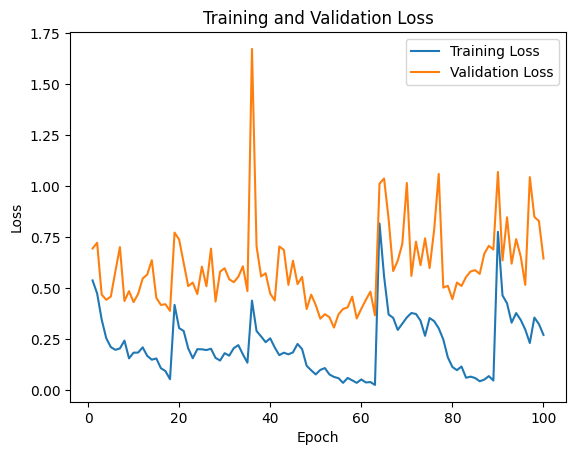

In [ ]:
plt.figure()
plt.plot(range(1, num_epochs + 1), avg_train_loss, label='Training Loss')
plt.plot(range(1, num_epochs + 1), avg_test_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()